In [27]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Cлучайный лес

In [2]:
digits = load_digits() #выгружаем данные
X = digits.data #признаки
y = digits.target #целевая перемнная

In [4]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [12]:
print(X.shape, y.shape)

(1797, 64) (1797,)


In [18]:
model = DecisionTreeClassifier() #классификатор решающего дерева
cv_score = cross_val_score(model, X, y, cv=10) #оценки по кросс-валидации
print(cv_score.shape) 
print(np.mean(cv_score)) 

(10,)
0.8258162631905648


In [22]:
bag_model = BaggingClassifier(model, n_estimators=100) #бэггинг над 100 решающими деревьями 
cv_score_bag = cross_val_score(bag_model, X, y, cv=10) #оценки по кросс-валидации
print(cv_score_bag.shape) 
print(np.mean(cv_score_bag))

(10,)
0.9198230912476724


Деревья неустойчивы к изменениям в обучающей выборке, поэтому в результате усреднения по деревьям, построенным на немного разных выборках (как это происходит в бэггинге), получается более точный ответ.

In [24]:
bag_model1 = BaggingClassifier(model, n_estimators=100, max_features=int(np.sqrt(X.shape[1])))  #бэггинг над 100 решающими деревьями 
#не на всех d признаках, а на корень из d случайных признаков
cv_score_bag1 = cross_val_score(bag_model1, X, y, cv=10) #оценки по кросс-валидации
print(cv_score_bag1.shape)
print(np.mean(cv_score_bag1))

(10,)
0.928767846058349


С добавлением выбора случайных признаков деревья стали различаться еще больше, в результате композиция работает лучше.

In [26]:
tree_model = DecisionTreeClassifier(splitter='random', max_features=int(np.sqrt(X.shape[1]))) #классификатор решающего дерева по случайному подмножеству признаков 
bag_model2 = BaggingClassifier(tree_model, n_estimators=100, bootstrap=False, max_features=int(np.sqrt(X.shape[1]))) #бэггинг на рандомизированных деревьях == Random Forest
cv_score_bag2 = cross_val_score(bag_model2, X, y, cv=10) #оценки по кросс-валидации
cv_score_tree = cross_val_score(tree_model, X, y, cv=10) #оценки по кросс-валидации
print(np.mean(cv_score_bag2))
print(np.mean(cv_score_tree)) 

0.933227808814401
0.7395530726256984


Если выбирать случайные признаки в каждой вершине, отличия между деревьями становятся еще более существенными, что хорошо сказывается на качестве работы композиции. Именно так и устроен случайный лес.

In [29]:
model_rfc = RandomForestClassifier() #случайный лес
cv_score_rfc = cross_val_score(model_rfc, X, y, cv=10) #оценки по кросс-валидации
print(np.mean(cv_score_rfc))

0.9465735567970205


In [30]:
num_trees = np.arange(1, 200, 10)
num_features = np.arange(1, X.shape[1]+1, 1)
depths = np.arange(1, 100, 5)

In [32]:
a = []
nn = 0
for i in num_trees:
    nn += 1
    print(nn)
    temp_tree = DecisionTreeClassifier(splitter='best')
    temp_model = BaggingClassifier(temp_tree, n_estimators=i)
    temp_score = cross_val_score(temp_model, X, y, cv=10)
    a.append(np.mean(temp_score))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


Text(0, 0.5, 'Score')

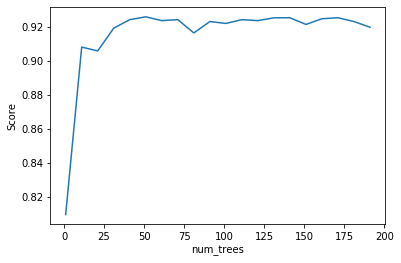

In [33]:
plt.plot(num_trees, a)
plt.xlabel("num_trees")
plt.ylabel("Score")

**Вывод: С ростом количества деревьев в случайном лесе, в какой-то момент деревьев становится достаточно для высокого качества классификации, а затем качество существенно не меняется. При этом, при очень маленьком числе деревьев, случайный лес работает хуже, чем при большем числе деревьев. При композиции алгоритмов разброс ошибки обратно пропорционален кол-ву алгоритмов, поэтому при маленьком числе деревьев качество хуже, чем при большом.**

In [35]:
nn = 0
for i in num_features:
    nn += 1
    print(nn)
    temp_tree = DecisionTreeClassifier(splitter='best', max_features=i)
    temp_model = BaggingClassifier(temp_tree, max_features=i)
    temp_score = cross_val_score(temp_model, X, y, cv=10)
    a.append(np.mean(temp_score))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64


Text(0, 0.5, 'Score')

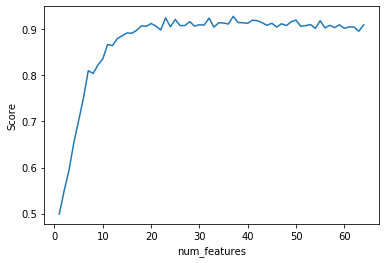

In [36]:
plt.plot(num_features, a[num_trees.shape[0]:])
plt.xlabel("num_features")
plt.ylabel("Score")

**Вывод: При большом количестве признаков (для данного датасета - 40, 50) качество классификации становится хуже, чем при малом количестве признаков. Это связано с тем, что чем меньше признаков выбирается в каждом узле, тем более различными получаются деревья (ведь деревья сильно неустойчивы к изменениям в обучающей выборке), и тем лучше работает их композиция.Чем меньше признаков, тем менее коррелированы становятся деревья. Но надо понимать, что слишком малое кол-во признаков не позволит “поймать” зависимость в данных.**

In [37]:
nn = 0
b = []
for i in depths:
    nn += 1
    print(nn)
    temp_tree = DecisionTreeClassifier(splitter='best', max_depth=i)
    temp_model = BaggingClassifier(temp_tree)
    temp_score = cross_val_score(temp_model, X, y, cv=10)
    b.append(np.mean(temp_score))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


Text(0, 0.5, 'Score')

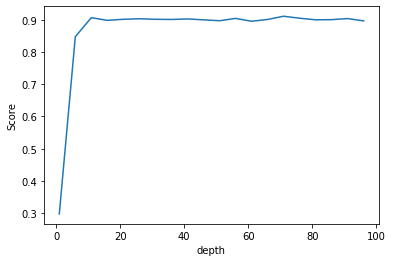

In [38]:
plt.plot(depths, b)
plt.xlabel("depth")
plt.ylabel("Score")

**Вывод: При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса заметно хуже, чем без ограничений, т.к. деревья получаются недообученными. С ростом глубины качество сначала улучшается, а затем не меняется существенно, т.к. из-за усреднения прогнозов и различий деревьев их переобученность в бэггинге не сказывается на итоговом качестве (все деревья преобучены по-разному, и при усреднении они компенсируют переобученность друг-друга).**